In [1]:
import sys
sys.path += ["../"]

import smbh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

In [2]:
axis = np.genfromtxt("axis.txt", skip_header = 1, delimiter = ', ')
speeds = np.genfromtxt("initial.txt", skip_header = 1, delimiter = ', ')
lyapunov = np.genfromtxt("lyapunov_exponents.txt")

# Axis

In [3]:
is_, a_1, a_2, a_3 = axis.T

In [4]:
A_2, A_3 = np.meshgrid(a_2, a_3)

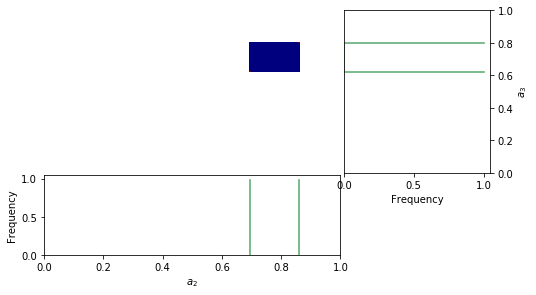

In [5]:
fig = plt.figure(figsize = (8, 4.5))

n_bins = 30
gs = GridSpec(3, 3)
gs.update(wspace = 0.025, hspace = 0.025) # set the spacing between axes. 

ax1 = plt.subplot(gs[:-1, :-1])
ax2 = plt.subplot(gs[-1, :-1])
ax3 = plt.subplot(gs[:-1, -1])

_ = ax1.hist2d(a_2, a_3, bins = n_bins, cmap = 'jet')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.axis('off')

ax2.hist(a_2, bins = n_bins, edgecolor = 'g', alpha = 0.4)
ax2.set_xlim(0, 1)

ax3.hist(a_3, bins = n_bins, orientation = 'horizontal', edgecolor = 'g', alpha = 0.4)
ax3.set_ylim(0, 1)

ax3.set_ylabel('$a_3$')
ax2.set_xlabel('$a_2$')

ax2.set_ylabel('Frequency')
ax3.set_xlabel('Frequency')

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

# fig.savefig('triaxial_axes.png', dpi = 300)

# Speeds

In [6]:
js_, rv_x, rv_y, rv_z = speeds.T

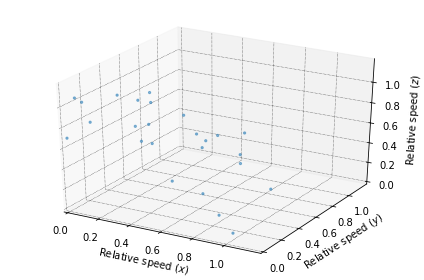

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(rv_x, rv_y, rv_z, alpha = 0.5, s = 5)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_zlim(0, 1.2)

ax.set_xlabel("Relative speed ($x$)")
ax.set_ylabel("Relative speed ($y$)")
ax.set_zlabel("Relative speed ($z$)")

fig.tight_layout()

fig.savefig("3d_initial_speeds.png", dpi = 300)

plt.show()

NameError: name 'r_labels' is not defined

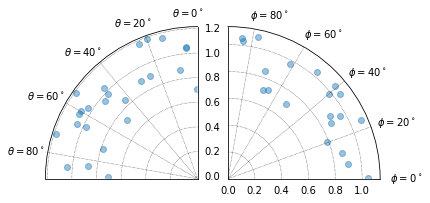

In [8]:
rv = (speeds[:, 1:] ** 2).sum(axis = 1) ** 0.5
phi = np.arctan2(rv_y, rv_x)
theta = np.arccos(rv_z / rv)

fig, (ax1, ax2) = smbh.makePolarPlot(rv, theta, phi)

fig.savefig("polar_initial_speeds.png", dpi = 300)
plt.show()

In [ ]:
return_times = np.genfromtxt('return_times.txt')
return_masses = np.genfromtxt('return_masses.txt')

In [ ]:
freq, bins = np.histogram(return_times[0][return_times[0] > 0], bins = 35)
centered = 0.5 * (bins[1:] + bins[:-1])

pos = freq > 0
freq = freq[pos]
centered = centered[pos]

plt.bar(centered, freq, width = 0.005)
plt.yscale('log')

In [ ]:
# %matplotlib

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

c = np.log10(return_times[0])

# s = np.exp(10 * (lyapunov[0] - lyapunov[0].min()) / lyapunov[0].max() + 2.5)

sc = ax.scatter(rv_x, rv_y, rv_z, c = c, alpha = 0.5, cmap = 'jet')

cb = plt.colorbar(sc)

cb.set_label('$\log_{10}($Return time (Gyr)$)$')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel("Relative speed ($x$)")
ax.set_ylabel("Relative speed ($y$)")
ax.set_zlabel("Relative speed ($z$)")

fig.tight_layout()

plt.show()

In [ ]:
rv = (speeds[:, 1:] ** 2).sum(axis = 1) ** 0.5
phi = np.arctan2(rv_y, rv_x)
theta = np.arccos(rv_z / rv)

fig, (ax1, ax2) = smbh.makePolarPlot(rv, theta, phi, colors = c)

plt.show()

In [ ]:
rv = (speeds[:, 1:] ** 2).sum(axis = 1) ** 0.5

phi = np.arctan2(rv_y, rv_x)
theta = np.arccos(rv_z / rv)

fig, (ax1, ax2) = smbh.makePolarPlot(rv, theta, phi, colors = lyapunov[0])

plt.show()

In [ ]:
p_min = return_times[0].argmin()
p_max = return_times[0].argmax()
return_times[0, p_min], return_times[0, p_max]

In [ ]:
p_min = 0
min_result = smbh.Results('Results/0_%d.dat' % p_min)
max_result = smbh.Results('Results/0_%d.dat' % p_max)

min_result.setDistance(*axis[0, 1:])

In [ ]:
smbh.plotOrbits([min_result])

In [ ]:
plt.plot(min_result.masses)